# Multi-output Gaussian Processes for Dose Response Predictions
## In this notebook:
1. We train a MOGP model using the GDSC1 dataset and then assess the performance of the model using the GDSC2 dataset as testing to obtained the summary metrics: IC50, AUC and Emax.
2. We generate a plot at the end to compare the fitted reference Sigmoid4_parameters function against the MOGP summary metric predictions.

## Train the model using GDSC1 Dataset

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler
import os
import matplotlib.pyplot as plt

plt.close('all')

_FOLDER = "./Dataset_BRAF_NoReplica_ANOVA_Features/GDSC1/"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
import getopt
import sys
sys.path.append('..')

warnings.filterwarnings("ignore")

In [2]:
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"In this cell we can configure different initalisation values for training the MOGP model"
"We mainly trained for the three drugs: 1036 (PLX-4720), 1061 (SB590885) and 1373 (Dabrafenib)"
"By default the config.Train = False, so as per the drug the following cell will load the models"
"already trained, if config.Train = True then the MOGP will train along all K-fold with the initial values"
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
class commandLine:
    def __init__(self):
        "TODO: check that Niter is actually used!!!!"
        self.N_iter = 30    #number of iterations
        self.which_seed = 1018    #change seed to initialise the hyper-parameters
        self.rank = 2
        self.scale = 1.0
        self.weight = 0.01
        self.bash = "946"
        self.drug_name = "1036"
        self.Train = False   #Switch to False if just want the load the already trained model
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
config = commandLine()
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"dictionary to map drug_id to drug_name"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
dict_drug_name = {1036:'PLX-4720',1061:'SB590885',1373:'Dabrafenib'}

In [3]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"Default configurations to load the already trained MOGP models"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
if config.drug_name == '1036' and config.Train == False:
    config.N_iter = 30;config.which_seed = 1018;config.rank = 2;config.scale = 1.0
    config.weight = 0.01;config.bash = "946";config.drug_name = "1036"
elif config.drug_name == '1061' and config.Train == False:
    config.N_iter = 30;config.which_seed = 1014;config.rank = 2;config.scale = 1.0
    config.weight = 1.0;config.bash = "505";config.drug_name = "1061"
elif config.drug_name == '1373' and config.Train == False:
    config.N_iter = 30;config.which_seed = 1013;config.rank = 2;config.scale = 1.0
    config.weight = 1.0;config.bash = "221";config.drug_name = "1373"

In [4]:
"#Bear in mind that the drugs 1061 and 1036 have 9 concentrations, i.e., d1, d2, d3, d4, d5, d6, d7, d8 and d9 "
"#but the drugs 1371 and 1373 have 5 concentrations, i.e, d1, d3, d5, d7 and d9"
"#Drugs 1036 and 1371 are the same one, but the former has 9 concentrations and the latter 5 concentrations"

dconcentr = {"1061": "9conc","1036": "9conc","1373": "5conc","1371": "5conc"}
feat_for_drug = {"1061": "2-fold","1036": "2-fold","1373": "4-fold","1371": "4-fold"}
name_for_KLrelevance = 'GDSC1_melanoma_BRAF_'+dconcentr[config.drug_name]+'_noreps_v3.csv'
name_ANOVA_feat_file = 'GDSC1_BRAFmelanoma_ANOVAfeatures_'+feat_for_drug[config.drug_name]+'.csv'

df_train_No_MolecForm = pd.read_csv(_FOLDER + name_for_KLrelevance)  # Contain Train dataset prepared by Subhashini-Evelyn
df_ANOVA_feat_Names = pd.read_csv(_FOLDER + name_ANOVA_feat_file)  # Contain Feature Names used by ANOVA
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
df_train_No_MolecForm = df_train_No_MolecForm[(df_train_No_MolecForm["DRUG_ID"]==int(config.drug_name))]
try:
    df_train_No_MolecForm = df_train_No_MolecForm.drop(columns='Drug_Name')
except:
    pass

# the column index 29 for Drug 1061 the input features start
# but column index 21 is for Drug 1373
if config.drug_name == "1061" or config.drug_name == "1036":
    Dnorm_cell = 9
    start_pos_features = 29
elif config.drug_name == "1373" or config.drug_name == "1371":
    Dnorm_cell = 5
    start_pos_features = 21

print(df_train_No_MolecForm.columns[start_pos_features])

ARID1A_mut


In [5]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"Scale the Genomic features to be between 0 and 1"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
scaler = MinMaxScaler().fit(df_train_No_MolecForm[df_train_No_MolecForm.columns[start_pos_features:]])
X_train_features = scaler.transform(df_train_No_MolecForm[df_train_No_MolecForm.columns[start_pos_features:]])
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"Here we extract from the dataframe the D outputs related to each dose concentration"
"Below we select 9 concentration since GDSC1 has that number for Drugs 1036 and 1061"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
y_train_drug = np.clip(df_train_No_MolecForm["norm_cells_" + str(1)].values[:, None], 1.0e-9, np.inf)
print(y_train_drug.shape)
for i in range(2, Dnorm_cell+1):
    y_train_drug = np.concatenate(
        (y_train_drug, np.clip(df_train_No_MolecForm["norm_cells_" + str(i)].values[:, None], 1.0e-9, np.inf)), 1)

print("Ytrain size: ", y_train_drug.shape)

(40, 1)
Ytrain size:  (40, 9)


In [6]:
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"Since we fitted the dose response curves with a Sigmoid4_parameters function"
"We extract the optimal coefficients in order to reproduce such a Sigmoid4_parameters fitting"
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
params_4_sig_train = df_train_No_MolecForm["param_" + str(1)].values[:, None]
for i in range(2, 5):  #here there are four params for sigmoid4
    params_4_sig_train = np.concatenate(
        (params_4_sig_train, df_train_No_MolecForm["param_" + str(i)].values[:, None]), 1)


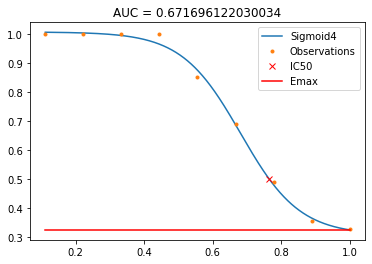

In [7]:
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"In this sections we will extract the summary metrics AUC, Emax and IC50 from the Sigmoid4_parameters functions"
"These metrics are used as the references to compute the error metrics"
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
from sklearn import metrics
from importlib import reload
import Utils_SummaryMetrics_KLRelevance
import Utils_SummaryMetrics_KLRelevance as MyUtils
reload(MyUtils)

"Be careful that x starts from 0.111111 for 9 or 5 drug concentrations in GDSC1 dataset"
"but x starts from 0.142857143 for the case of 7 drug concentrations in GDSC2 dataset"
"The function Get_IC50_AUC_Emax is implemented in Utils_SummaryMetrics_KLRelevance.py to extract the summary metrics"
x_lin = np.linspace(0.111111, 1, 1000)
x_real_dose = np.linspace(0.111111, 1, Dnorm_cell)  #Here is Dnorm_cell due to using GDSC1 that has 9 or 5 doses
Ydose50,Ydose_res,IC50,AUC,Emax = MyUtils.Get_IC50_AUC_Emax(params_4_sig_train,x_lin,x_real_dose)

def my_plot(posy,fig_num,Ydose50,Ydose_res,IC50,AUC,Emax,x_lin,x_real_dose,y_train_drug):
    plt.figure(fig_num)
    plt.plot(x_lin, Ydose_res[posy])
    plt.plot(x_real_dose, y_train_drug[posy, :], '.')
    plt.plot(IC50[posy], Ydose50[posy], 'rx')
    plt.plot(x_lin, np.ones_like(x_lin)*Emax[posy], 'r') #Plot a horizontal line as Emax
    plt.title(f"AUC = {AUC[posy]}")
    plt.legend(['Sigmoid4','Observations','IC50','Emax'])

"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"Here we can visualise the values of the GDSC1 dataset with the fitting of Sigmoid4_parameters function"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
posy = 10   #select the location you want to plot, do not exceed the Ytrain length
my_plot(posy,0,Ydose50,Ydose_res,IC50,AUC,Emax,x_lin,x_real_dose,y_train_drug)

In [8]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"Organize summary metrics with proper dimensionality"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
AUC = np.array(AUC)
IC50 = np.array(IC50)
Emax = np.array(Emax)

"Below we select just the columns with std higher than zero"
Name_Features_Melanoma = df_train_No_MolecForm.columns[start_pos_features:]
Xall = X_train_features.copy()
Yall = y_train_drug.copy()

print("Sanity check to the same features Evelyin Provided")
print(df_ANOVA_feat_Names["feature"].values[start_pos_features:]==Name_Features_Melanoma)

AUC_all = AUC[:, None].copy()
IC50_all = IC50[:, None].copy()
Emax_all = Emax[:, None].copy()

print("AUC train size:", AUC_all.shape)
print("IC50 train size:", IC50_all.shape)
print("Emax train size:", Emax_all.shape)
print("X all data size:", Xall.shape)
print("Y all data size:", Yall.shape)

Sanity check to the same features Evelyin Provided
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True]
AUC train size: (40, 1)
IC50 train size: (40, 1)
Emax train size: (40, 1)
X all data size: (40, 24)
Y all data size: (40, 9)


In [9]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"Create a K-fold for cross-validation"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
from sklearn.model_selection import KFold, cross_val_score
Ndata = Xall.shape[0]
Xind = np.arange(Ndata)
nsplits = 20 #Ndata
k_fold = KFold(n_splits=nsplits)
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
NegMLL_AllFolds = []
Emax_abs_AllFolds = []
AUC_abs_AllFolds = []
IC50_MSE_AllFolds = []
Med_MSE_AllFolds = []
AllPred_MSE_AllFolds = []
Mean_MSE_AllFolds = []
All_Models = []
Ntasks = Dnorm_cell

In [10]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"MOGP model Training process"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
NegMLL_AllFolds = []
Emax_abs_AllFolds = []
AUC_abs_AllFolds = []
IC50_MSE_AllFolds = []
Med_MSE_AllFolds = []
AllPred_MSE_AllFolds = []
Mean_MSE_AllFolds = []
All_Models = []
Ntasks = Dnorm_cell
list_folds = list(k_fold.split(Xall))
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"The for loop below runs the cross-validation process for the MOGP model"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
for Nfold in range(0,nsplits+1):
    model = []
    "The first if below is for the cross-val"
    "Then the else is for using all data to save the model trained over all data"
    Xtrain,Ytrain,Xval,Xval_aux,Yval,Emax_val,IC50_val,AUC_val=MyUtils.ArrangeData_to_CrossVal(Ntasks,Nfold,nsplits,list_folds,Xall,Yall,Emax_all,IC50_all,AUC_all)
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    import GPy
    # os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
    mean_all = np.zeros_like(Yval)
    models_outs = []

    rank = int(config.rank)  # Rank for the MultitaskKernel
    "Below we substract one due to being the label associated to the output"
    Dim = Xtrain.shape[1]-1
    myseed = int(config.which_seed)
    np.random.seed(myseed)
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    "Product Kernels. Below we use the locations:"
    "Kernel1 accounts for locations 0:11 for Mutation"
    "Kernel2 accounts for locations 11:end for PANCAN"
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    split_dim = 2
    AddKern_loc = [11, Dim]
    mykern = GPy.kern.RBF(AddKern_loc[0], active_dims=list(np.arange(0, AddKern_loc[0])))
    print(list(np.arange(0, AddKern_loc[0])))
    for i in range(1, split_dim):
        mykern = mykern * GPy.kern.RBF(AddKern_loc[i]-AddKern_loc[i-1],active_dims=list(np.arange(AddKern_loc[i-1], AddKern_loc[i])))
        print(list(np.arange(AddKern_loc[i-1], AddKern_loc[i])))

    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    "Random Initialization of the kernel hyper-parameters"
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    mykern.rbf.lengthscale = float(config.scale)* np.sqrt(Dim) * np.random.rand()
    mykern.rbf.variance.fix()
    for i in range(1,split_dim):
        eval("mykern.rbf_"+str(i)+".lengthscale.setfield(float(config.scale)* np.sqrt(Dim) * np.random.rand(), np.float64)")
        eval("mykern.rbf_" + str(i) + ".variance.fix()")

    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    "Create the coregionalization kernel for the MOGP model and create the MOGPRegression model"
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    kern = mykern ** GPy.kern.Coregionalize(1, output_dim=Ntasks,rank=rank)
    model = GPy.models.GPRegression(Xtrain, Ytrain, kern)
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    "Random Initialization of the linear combination coefficients for coregionalization matrix of MOGP"
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    Init_Ws = float(config.weight) * np.random.randn(Ntasks,rank)
    model.kern.coregion.W = Init_Ws
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    "If config.Train is True we will train the models for all Kfold to estimate performance of the seed"
    "On the contrary, if config.Train is False we do not train but load the already best Trained model"
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    if config.Train:
        #model.optimize(optimizer='lbfgsb',messages=True,max_iters=int(config.N_iter))
        model.optimize()
    else:
        # Here we load the model bash*:
        m_trained = str(config.bash)
        print("loading model ", m_trained)
        model[:] = np.load('./GDSC1_Codes_ANOVAFeatures/Best_Model_Drug' + config.drug_name + '_MelanomaGDSC1_GPy_ANOVA_ExactMOGP_ProdKern/m_' + m_trained + '.npy')
    
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    "Make predictions for the Kfold-out"
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    m_pred, v_pred = model.predict(Xval, full_cov=False)
    Yval_curve = Yval.reshape(Ntasks, Xval_aux.shape[0]).T.copy()
    m_pred_curve = m_pred.reshape(Ntasks, Xval_aux.shape[0]).T.copy()
    v_pred_curve = v_pred.reshape(Ntasks, Xval_aux.shape[0]).T.copy()

    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    "Here we extract the summary metrics AUC, Emax and IC50 from the MOGP curve predictions"
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    x_dose = np.linspace(0.111111, 1.0, Ntasks)
    x_dose_new = np.linspace(0.111111, 1.0, 1000)  #This new lispace is for the pchip interpolation
    Y_pred_interp_all,std_upper_interp_all,std_lower_interp_all,_, Ydose50_pred, IC50_pred, AUC_pred, Emax_pred = MyUtils.Predict_Curve_and_SummaryMetrics(x_dose =x_dose,x_dose_new = x_dose_new,m_pred_curve=m_pred_curve, v_pred=v_pred)

    Ydose50_pred = np.array(Ydose50_pred)
    IC50_pred = np.array(IC50_pred)[:,None]
    AUC_pred = np.array(AUC_pred)[:, None]
    Emax_pred = np.array(Emax_pred)[:, None]
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    "Compute different error metrics!"
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    Val_NMLL = -np.mean(model.log_predictive_density(Xval, Yval))  #Negative Log Predictive Density (NLPD)
    Emax_abs = np.mean(np.abs(Emax_val - Emax_pred))
    AUC_abs = np.mean(np.abs(AUC_val - AUC_pred))
    IC50_MSE = np.mean((IC50_val - IC50_pred) ** 2)
    MSE_curves = np.mean((m_pred_curve - Yval_curve) ** 2, 1)
    AllPred_MSE = np.mean((m_pred_curve - Yval_curve) ** 2)

    Med_MSE = np.median(MSE_curves)
    Mean_MSE = np.mean(MSE_curves)

    if Nfold < nsplits:
        print(f'\nError Metrics fold {Nfold}:')
        print("\nNegLPD Val", Val_NMLL)
        print("IC50 MSE:", IC50_MSE)
        print("AUC MAE:", AUC_abs)
        print("Emax MAE:", Emax_abs)
        print("Med_MSE:", Med_MSE)
        print("Mean_MSE:", Mean_MSE)
        print("All Predictions MSE:", AllPred_MSE)

        NegMLL_AllFolds.append(Val_NMLL.copy())
        Emax_abs_AllFolds.append(Emax_abs.copy())
        AUC_abs_AllFolds.append(AUC_abs.copy())
        IC50_MSE_AllFolds.append(IC50_MSE.copy())
        Med_MSE_AllFolds.append(Med_MSE.copy())
        Mean_MSE_AllFolds.append(Mean_MSE.copy())
        AllPred_MSE_AllFolds.append(AllPred_MSE.copy())

    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

[0 1] to Val in IC50
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
loading model  946

Error Metrics fold 0:

NegLPD Val 0.4508376841579971
IC50 MSE: 0.6078293579329678
AUC MAE: 0.19607374118774165
Emax MAE: 0.16059862000022734
Med_MSE: 0.0723794975896675
Mean_MSE: 0.0723794975896675
All Predictions MSE: 0.0723794975896675
[2 3] to Val in IC50
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
loading model  946

Error Metrics fold 1:

NegLPD Val 1.0628466794889202
IC50 MSE: 0.7359042462949372
AUC MAE: 0.4108794265888157
Emax MAE: 0.5150502374300431
Med_MSE: 0.32506275074416635
Mean_MSE: 0.32506275074416635
All Predictions MSE: 0.32506275074416635
[4 5] to Val in IC50
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
loading model  946

Error Metrics fold 2:

NegLPD Val -0.22477334352346773
IC50 MSE: 0.1908787632639253
AUC MAE: 0.0895706649101686
Emax MAE: 0.234665204749

In [11]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"Cross validation performance of the current seed"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
print('Metrics of Seed performance along K-folds (mean +/- std):\n')
print(f'dose response curve MSE: {np.mean(AllPred_MSE_AllFolds)} +/- {np.std(AllPred_MSE_AllFolds)}')
print(f'NegLog Predictive Density: {np.mean(NegMLL_AllFolds)} +/- {np.std(NegMLL_AllFolds)}')
print(f'IC50 MSE: {np.mean(IC50_MSE_AllFolds)} +/- {np.std(IC50_MSE_AllFolds)}')
print(f'AUC MAE: {np.mean(AUC_abs_AllFolds)} +/- {np.std(AUC_abs_AllFolds)}')
print(f'Emax MAE: {np.mean(Emax_abs_AllFolds)} +/- {np.std(Emax_abs_AllFolds)}')

Metrics of Seed performance along K-folds (mean +/- std):

dose response curve MSE: 0.09890452302286187 +/- 0.10212468855804228
NegLog Predictive Density: 0.1702506861092739 +/- 0.7642101297150027
IC50 MSE: 0.32785337163389927 +/- 0.30482092447514886
AUC MAE: 0.19411497851573462 +/- 0.12222080463413161
Emax MAE: 0.25474276565271287 +/- 0.17267962741933504


In [12]:
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"Below we prepare the data for Test over cell-lines from GDSC2 with 7 Doses, i.e. for Drug_id 1036"
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

_FOLDER_GDSC2 = "./Dataset_BRAF_NoReplica_ANOVA_Features/GDSC2/"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
name_for_KLrelevance_GDSC2 = 'GDSC2_melanoma_BRAF_noreps_v3.csv'

df_train_No_MolecForm_GDSC2 = pd.read_csv(_FOLDER_GDSC2 + name_for_KLrelevance_GDSC2)  # Contain Train dataset prepared by Subhashini-Evelyn
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
df_train_GDSC2 = df_train_No_MolecForm_GDSC2[(df_train_No_MolecForm_GDSC2["DRUG_ID"]==int(config.drug_name))]
try:
    df_train_GDSC2 = df_train_GDSC2.drop(columns='Drug_Name')
except:
    pass

# Here we just check that from the column index 25 the input features start
start_pos_features_GDSC2 = 25
print(df_train_GDSC2.columns[start_pos_features_GDSC2])

ARID1A_mut


# We test the MOGP model (trained on GDSC1) over the GDSC2 dataset

In [13]:
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"Below we use exactly the same features used for the training on GDSC1 their names are in Name_Features_Melanoma"
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
X_train_features_GDSC2_NonScaled = df_train_GDSC2[Name_Features_Melanoma].copy()
"Instead of using (MaxMin sclaer) scaler.transform we just extract the min and max and make the transformation"
"This is to directly use the features used for training GDSC1 Dose9 and Dose5"
scaler_sel_max = scaler.data_max_
scaler_sel_min = scaler.data_min_
Xall_GDSC2 = (X_train_features_GDSC2_NonScaled.values-scaler_sel_min)/(scaler_sel_max-scaler_sel_min)

"Below we select just 7 concentration since GDSC2 only has such a number"
y_train_drug_Dose7 = np.clip(df_train_GDSC2["norm_cells_" + str(1)].values[:, None], 1.0e-9, np.inf)
print(y_train_drug_Dose7.shape)
for i in range(2, 8):
    y_train_drug_Dose7 = np.concatenate(
        (y_train_drug_Dose7, np.clip(df_train_GDSC2["norm_cells_" + str(i)].values[:, None], 1.0e-9, np.inf)), 1)

print("Ytrain size: ", y_train_drug_Dose7.shape)

(50, 1)
Ytrain size:  (50, 7)


In [14]:
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
params_4_sig_train_Dose7 = df_train_GDSC2["param_" + str(1)].values[:, None]
for i in range(2, 5):
    params_4_sig_train_Dose7 = np.concatenate(
        (params_4_sig_train_Dose7, df_train_GDSC2["param_" + str(i)].values[:, None]), 1)

0.4751255929265776


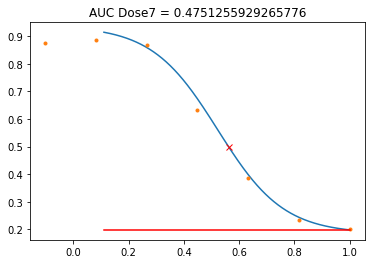

In [15]:
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
import matplotlib.pyplot as plt
from sklearn import metrics

#plt.close('all')
Kprop = (20.5-3.95)*(1-0.111111)/20.5
xini_adjusted = 0.111111 + ((1-0.111111)-Kprop)
ToMul = (1-0.111111)/Kprop
weighted = (1-0.111111)*ToMul
difference = weighted- (1-0.111111)
x_lin_Dose7 = np.linspace(0.111111, 1, 1000)
x_lin_Dose7_Adjust = np.linspace(xini_adjusted, 1, 1000)
x_real_dose_Dose7 = np.linspace(0.111111-difference, 1, 7)  #Here is 7 due to using GDSC2 that has 7 doses
x_lin_tile_Dose7 = np.tile(x_lin_Dose7, (params_4_sig_train_Dose7.shape[0], 1))
x_lin_tile_Dose7_Adjust = np.tile(x_lin_Dose7_Adjust, (params_4_sig_train_Dose7.shape[0], 1))
# (x_lin,params_4_sig_train.shape[0],1).shape
Ydose_res_Dose7 = []
AUC_Dose7 = []
IC50_Dose7 = []
Ydose50_Dose7 = []
Emax_Dose7 = []
for i in range(params_4_sig_train_Dose7.shape[0]):
    Ydose_res_Dose7.append(MyUtils.sigmoid_4_param(x_lin_tile_Dose7_Adjust[i, :], *params_4_sig_train_Dose7[i, :]))
    AUC_Dose7.append(metrics.auc(x_lin_tile_Dose7[i, :], Ydose_res_Dose7[i]))
    Emax_Dose7.append(Ydose_res_Dose7[i][-1])
    res1 = (Ydose_res_Dose7[i] < 0.507)
    res2 = (Ydose_res_Dose7[i] > 0.493)
    if (res1 & res2).sum() > 0:
        Ydose50_Dose7.append(Ydose_res_Dose7[i][res1 & res2].mean())
        IC50_Dose7.append(x_lin_Dose7[res1 & res2].mean())
    elif Ydose_res_Dose7[i][-1]<0.5:
       Ydose50_Dose7.append(Ydose_res_Dose7[i].max())
       aux_IC50_Dose7 = x_lin_Dose7[np.where(Ydose_res_Dose7[i].max())[0]][0]  #it has to be a float not an array to avoid bug
       IC50_Dose7.append(aux_IC50_Dose7)
    else:
        Ydose50_Dose7.append(0.5)
        IC50_Dose7.append(1.5) #IC50.append(x_lin[-1])

posy = 3
plt.figure(10)
plt.plot(x_lin_Dose7, Ydose_res_Dose7[posy])
plt.plot(x_real_dose_Dose7, y_train_drug_Dose7[posy, :], '.')
plt.plot(IC50_Dose7[posy], Ydose50_Dose7[posy], 'rx')
plt.plot(x_lin_Dose7, np.ones_like(x_lin_Dose7)*Emax_Dose7[posy], 'r') #Plot a horizontal line as Emax
plt.title(f"AUC Dose7 = {AUC_Dose7[posy]}")
print(AUC_Dose7[posy])

In [16]:
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
AUC_Dose7 = np.array(AUC_Dose7)[:,None]
IC50_Dose7 = np.array(IC50_Dose7)[:,None]
Emax_Dose7 = np.array(Emax_Dose7)[:,None]

In [17]:
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"The Xtest_aux_Dose7 data should have labels of Ntask equal to the size of GDSC1, for instance if using Drug1036"
"then we should assign labels for 9 concentrations, that is because the models trained on GDSC1 presented"
"9 concentration, so when we predict using the model we will obtain 9 predictions."

Xtest_aux_Dose7 = Xall_GDSC2.copy()
Ylabel_test_Dose7 = np.array([i * np.ones(Xtest_aux_Dose7.shape[0]) for i in range(Ntasks)]).flatten()[:, None]
Xtest_GDSC2_Dose7 = np.concatenate((np.tile(Xtest_aux_Dose7, (Ntasks, 1)), Ylabel_test_Dose7), 1)
Ytest_Dose7 = y_train_drug_Dose7.T.flatten().copy()[:, None]

m_pred_Dose7, v_pred_Dose7 = model.predict(Xtest_GDSC2_Dose7, full_cov=False)

Nval_Dose7 = Xtest_aux_Dose7.shape[0]

m_pred_curve_Dose7 = m_pred_Dose7.reshape(Ntasks, Nval_Dose7).T.copy()
v_pred_curve_Dose7 = v_pred_Dose7.reshape(Ntasks, Nval_Dose7).T.copy()

We only predict the region that overlaps between GDSC1 and GDSC2 dataset


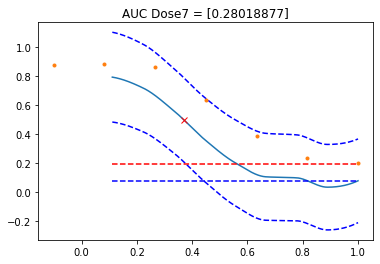

In [18]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"Interpolation of predictions for GDSC2 for Dose7"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
if Ntasks == 9:
    assert Ntasks == 9

x_dose_Dose7 = np.linspace(0.111111, 1.0, Ntasks)  # Here 9 due to having 9 dose responses for GDSC1 prediction
x_dose_new_Dose7 = np.linspace(0.111111, 1.0, 1000)
Y_pred_interp_all_Dose7,std_upper_interp_all_Dose7,std_lower_interp_all_Dose7,_, Ydose50_pred_Dose7, IC50_pred_Dose7, AUC_pred_Dose7, Emax_pred_Dose7 = MyUtils.Predict_Curve_and_SummaryMetrics(x_dose =x_dose_Dose7,x_dose_new = x_dose_new_Dose7,m_pred_curve=m_pred_curve_Dose7, v_pred=v_pred_Dose7)

Ydose50_pred_Dose7 = np.array(Ydose50_pred_Dose7)
IC50_pred_Dose7 = np.array(IC50_pred_Dose7)[:, None]
AUC_pred_Dose7 = np.array(AUC_pred_Dose7)[:, None]
Emax_pred_Dose7 = np.array(Emax_pred_Dose7)[:, None]

#posy = 11
plt.figure(60)
plt.plot(x_dose_new_Dose7, Y_pred_interp_all_Dose7[posy])
plt.plot(x_dose_new_Dose7, std_upper_interp_all_Dose7[posy], 'b--')
plt.plot(x_dose_new_Dose7, std_lower_interp_all_Dose7[posy], 'b--')
#plt.plot(x_dose_Dose7, Yval_curve_Dose7[posy, :], '.')
plt.plot(x_real_dose_Dose7, y_train_drug_Dose7[posy, :], '.')
plt.plot(IC50_pred_Dose7[posy], Ydose50_pred_Dose7[posy], 'rx')
plt.plot(x_dose_new_Dose7, np.ones_like(x_dose_new_Dose7) * Emax_pred_Dose7[posy],'b--')  # Plot a horizontal line as Emax
plt.plot(x_dose_new_Dose7, np.ones_like(x_dose_new_Dose7) * Emax_Dose7[posy],'r--')  # Plot a horizontal line as Emax
plt.title(f"AUC Dose7 = {AUC_pred_Dose7[posy]}")
print('We only predict the region that overlaps between GDSC1 and GDSC2 dataset')

In [19]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"Error in summary metrics between fitted Sigmoid4 parameters and MOGP model"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
Emax_abs_Dose7 = np.mean(np.abs(Emax_Dose7 - Emax_pred_Dose7))
AUC_abs_Dose7 = np.mean(np.abs(AUC_Dose7 - AUC_pred_Dose7))
IC50_MSE_Dose7 = np.mean((IC50_Dose7 - IC50_pred_Dose7) ** 2)

print("IC50 MSE:", IC50_MSE_Dose7)
print("AUC MAE:", AUC_abs_Dose7)
print("Emax MAE:", Emax_abs_Dose7)

IC50 MSE: 0.20032066052624586
AUC MAE: 0.1161292772768471
Emax MAE: 0.15921495720139325


In [20]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"We will create a dataframe to plot summary predictions of MOGP (Trained on GDSC1) tested on GDSC2"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
columns_to_pick = list(df_train_GDSC2.columns[0:5])+['BRAF_mut']
#df_train_No_MolecForm[df_train_No_MolecForm.columns[0:6]]
TrainedGDSC1_PredictGDSC2 = df_train_GDSC2[columns_to_pick]

""""""""""""""""""""""""""""""""""""""""""""""""""""""
"Include data from fitted Sigmoid4 parameters fuction"
""""""""""""""""""""""""""""""""""""""""""""""""""""""
TrainedGDSC1_PredictGDSC2['IC50_s4'] = IC50_Dose7
TrainedGDSC1_PredictGDSC2['AUC_s4'] = AUC_Dose7
TrainedGDSC1_PredictGDSC2['Emax_s4'] = Emax_Dose7

"""""""""""""""""""""""""""""""""""""""
"Include data from MOGP predictions"
"""""""""""""""""""""""""""""""""""""""
TrainedGDSC1_PredictGDSC2['IC50_MOGP'] = IC50_pred_Dose7
TrainedGDSC1_PredictGDSC2['AUC_MOGP'] = AUC_pred_Dose7
TrainedGDSC1_PredictGDSC2['Emax_MOGP'] = Emax_pred_Dose7

In [21]:
# Define the mapping of levels and labels
level_mapping = {0: "WT", 1: "Mut"}

In [22]:
# Apply the mapping to create the new column BRAF_mut_2
TrainedGDSC1_PredictGDSC2['BRAF_mut_2'] = TrainedGDSC1_PredictGDSC2['BRAF_mut'].map(level_mapping)

In [23]:
import matplotlib.ticker as ticker
import seaborn as sns
from scipy.stats import pearsonr

# Function to create the scatter plot with regression line and text label
def create_scatter_plot(df, title, ax, xlim_scatter, ylim_scatter, xlim_regression, ylim_regression,metric_name='IC50'):
    
    # Define the amount of jitter
    jitter_amount = 0.03  # Adjust the amount of jitter as needed
    
    # Add jitter to the x and y coordinates to allow visualising the data that overlaps!!
    df[metric_name+'_MOGP_jittered'] = df[metric_name+'_MOGP'] + np.random.uniform(-jitter_amount, jitter_amount, len(df))
    df[metric_name+'_s4_jittered'] = df[metric_name+'_s4'] + np.random.uniform(-jitter_amount, jitter_amount, len(df))
    
    # Set the x-axis and y-axis limits for the scatter plot
    ax.set_xlim(xlim_scatter)
    ax.set_ylim(ylim_scatter)
    
    sns.scatterplot(data=df, x=metric_name+'_MOGP_jittered', y=metric_name+'_s4_jittered', hue='BRAF_mut_2', palette=['#009E73', '#CC79A7'], hue_order=['WT', 'Mut'], alpha=0.55, ax=ax)
    
    # Calculate and plot the regression line manually
    x_reg = df[metric_name+'_MOGP']
    y_reg = df[metric_name+'_s4']
    slope, intercept = np.polyfit(x_reg, y_reg, 1)  # Calculate the slope and intercept
    x_range = np.linspace(xlim_regression[0], xlim_regression[1], 100)  # Define the x-axis range for the regression line
    y_range = slope * x_range + intercept  # Calculate the corresponding y-values
    ax.plot(x_range, y_range, color='darkgrey', lw=1.8)  # Plot the extended regression line
    
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.4))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.4))
    ax.set_xlabel('MOGP predicted '+metric_name, fontsize=14)
    ax.set_ylabel('Sig4 derived '+metric_name, fontsize=14)
    ax.get_legend().remove()
    #ax.legend(title='BRAF', loc='lower left')
    
    # Calculate Pearson correlation coefficient and p-value
    r, p_value = pearsonr(df[metric_name+'_MOGP'], df[metric_name+'_s4'])

    if metric_name == 'Emax':
        ax.annotate(f'r = {r:.3f}', xy=(0.08, 1.0), color='black', size=12.5, va='center')
    elif metric_name == 'AUC':
        ax.annotate(f'r = {r:.3f}', xy=(0.08, 1.0), color='black', size=12.5, va='center')
    elif metric_name == 'IC50':
        ax.annotate(f'r = {r:.3f}', xy=(0.08, 1.57), color='black', size=12.5, va='center')

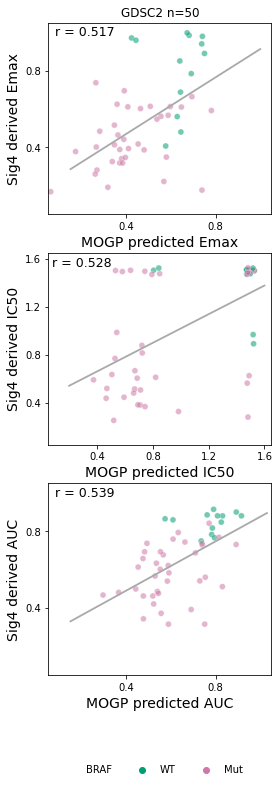

In [24]:
# Create subplots for both plots

fig, axes = plt.subplots(3, 1, figsize=(4, 12))
axes[0].set_title(f'GDSC2 n={IC50_Dose7.shape[0]}')
#fig, axes = plt.subplots(1, 2, figsize=(10, 4))

create_scatter_plot(TrainedGDSC1_PredictGDSC2, 'TrainedGDSC1_PredictGDSC2', axes[0],
                   xlim_scatter=(0.05, 1.05),  # Scatter plot axis limits
                        ylim_scatter=(0.05, 1.05),  # Scatter plot axis limits
                        xlim_regression=(0.15, 1.0),   # Regression line axis limits
                        ylim_regression=(0.15, 1.0),
                    metric_name = 'Emax'
                   )
create_scatter_plot(TrainedGDSC1_PredictGDSC2, 'TrainedGDSC1_PredictGDSC2', axes[1],
                   xlim_scatter=(0.05, 1.65),  # Scatter plot axis limits
                        ylim_scatter=(0.05, 1.65),  # Scatter plot axis limits
                        xlim_regression=(0.2, 1.6),   # Regression line axis limits
                        ylim_regression=(0.2, 1.6),
                    metric_name = 'IC50'
                   )
create_scatter_plot(TrainedGDSC1_PredictGDSC2, 'TrainedGDSC1_PredictGDSC2', axes[2],
                   xlim_scatter=(0.05, 1.05),  # Scatter plot axis limits
                        ylim_scatter=(0.05, 1.05),  # Scatter plot axis limits
                        xlim_regression=(0.15, 1.03),   # Regression line axis limits
                        ylim_regression=(0.15, 1.03),
                    metric_name = 'AUC'
                   )

# Adjusting legend position 
h, l = plt.gca().get_legend_handles_labels()
ph=[plt.plot([], marker="", ls="")[0]] #canvas
fig.legend(handles=ph+h,labels=["BRAF"]+l, loc='lower center', bbox_to_anchor=(0.48, -.001), ncol=3, frameon=False)

# Display the plots side by side
plt.subplots_adjust(wspace=0.1)
plt.show()